In [1]:
# general
import warnings
from tqdm import tqdm
from datasets import load_dataset
import time
from collections import defaultdict
from transforms.PermuteImage import PermuteImage
from os.path import isfile

# ML
import numpy as np
import pandas as pd

# visual
import matplotlib.pyplot as plt
import seaborn as sns

# # DL
import torch
from torch.nn import Module
import cv2
from torch import nn, Tensor
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset
from torchvision import transforms, models
from modules.HeadlessPretrainedModule import HeadlessPretrainedModule
from modules.CustomModule import CustomModule
from modules.CustomModule import CustomModule2
from transforms.Transform_Builder import Transform_Builder
from modules.VitModule import VitModule

warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED = 42

In [2]:
def denormalize(tensor, mean, std):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [3]:
dataset = load_dataset("cats_vs_dogs", trust_remote_code=True, verification_mode='no_checks')
dataset = dataset['train']

In [5]:
splitted_dataset = dataset.train_test_split(test_size=0.05, shuffle=True, seed=SEED)
train_val_dataset = splitted_dataset['train'].train_test_split(test_size=0.05, shuffle=True, seed=SEED)

In [6]:
train = train_val_dataset['train']
val = train_val_dataset['test']
test = splitted_dataset['test']

In [33]:
premutation_dict = {}
tiles_num = 9
tiles_per_row = int(np.sqrt(tiles_num))
tiles_arr = np.arange(tiles_num).reshape(tiles_per_row,tiles_per_row)
premutation_dict["same"]  = list(np.arange(tiles_num))
premutation_dict["1_col"]  = list(np.hstack([tiles_arr[:,0][::-1].reshape(-1,1), tiles_arr[:,1:]]).flatten())
premutation_dict["last_col"]  = list(np.hstack([tiles_arr[:,:-1],tiles_arr[:,-1][::-1].reshape(-1,1)]).flatten())
premutation_dict["middle_cols"] = list(np.hstack([tiles_arr[:,0].reshape(-1,1),tiles_arr[:,1:-1][::-1],tiles_arr[:,-1].reshape(-1,1)]).flatten())
premutation_dict["1_row"]  = list(np.vstack([tiles_arr[0,:][::-1], tiles_arr[1:, :]]).flatten())
premutation_dict["last_row"]  = list(np.vstack([tiles_arr[:-1, :], tiles_arr[-1,:][::-1]]).flatten())

premutation_dict["vertical_swap"] = list(tiles_arr[:,np.arange(tiles_per_row)[::-1]].flatten())
horizontal_swap = tiles_arr[np.arange(tiles_per_row)[::-1],:]
premutation_dict["horizontal_swap"] = list(horizontal_swap.flatten())
premutation_dict["double_swap"] = list(np.arange(tiles_num)[::-1])
premutation_dict["flip90"] = list(tiles_arr.T[:,np.arange(tiles_per_row)[::-1]].flatten())

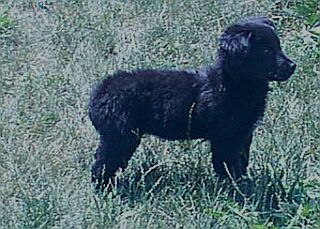

In [244]:
img1 =test[0]["image"]
img1

In [246]:
#images = PermuteImage.permute_by_defined_premutations(torch.permute(transforms.PILToTensor()(img1),(1,2,0)), list(premutation_dict.values()))

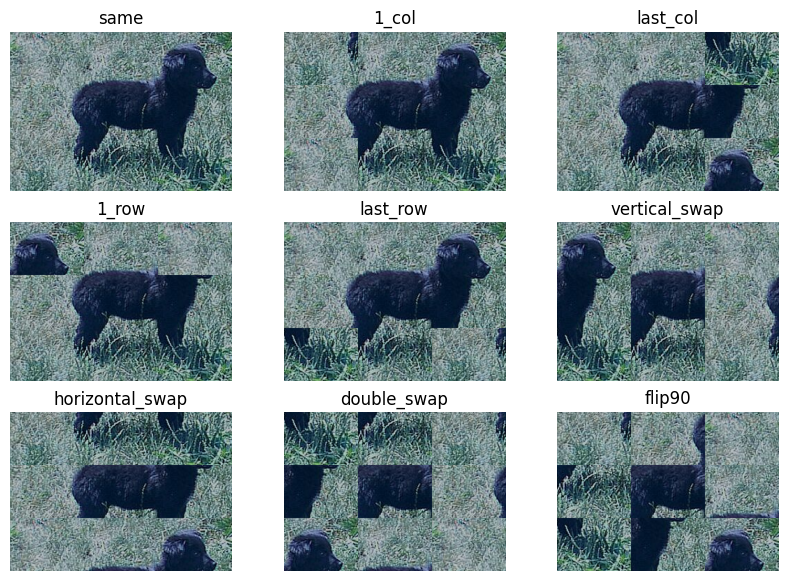

In [247]:
fig, axes = plt.subplots(3, 3, figsize=(10, 7))
axes = axes.flatten()
for i, key in enumerate(premutation_dict.keys()):
    # img = np.transpose(img, (1, 2, 0))  # Transpose to (H, W, C)
    axes[i].imshow(images[i,:])
    axes[i].set_title(key)
    axes[i].axis('off')
plt.show();

### Fine Tune pretrained model with specific permutation:

In [6]:
test_set = test.with_transform(Transform_Builder.build(224))
train_set = train.with_transform(Transform_Builder.build(224))
val_set = val.with_transform(Transform_Builder.build(224))

In [100]:
torch.permute(transforms.PILToTensor()(img1),(1,2,0)).shape

torch.Size([229, 320, 3])

In [13]:
pretrained_model = HeadlessPretrainedModule(pretrained_model = models.resnet50(pretrained=True), device=device)
pretrained_model = pretrained_model.to(device)
if isfile("./pretrained_model.pth"):
    pretrained_model.load_state_dict(torch.load("./pretrained_model.pth"))
else:
    lr = 5e-3
    num_epochs = 5

    optimizer = torch.optim.SGD(pretrained_model.parameters(), lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    pretrained_model.start_train(criterion, optimizer, dataloaders)
    torch.save(pretrained_model.state_dict(), "./pretrained_model.pth")

In [94]:
dataloaders = {
    'train': DataLoader(train_set, batch_size=32, drop_last=True, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=32, drop_last=True, num_workers=0),
    'test': DataLoader(test_set, batch_size=32, drop_last=True, num_workers=0),
}

In [ ]:
pretrained_model.start_train(criterion, optimizer, dataloaders, num_epochs=10)

### question 3

In [7]:
permuted_test_set = test.with_transform(Transform_Builder.build(224,with_premute=True))

In [64]:
test_set = test.with_transform(Transform_Builder.build(224))

In [65]:
img = test_set[0]["image"]

In [17]:
premuted_img = permuted_test_set[0]["image"]

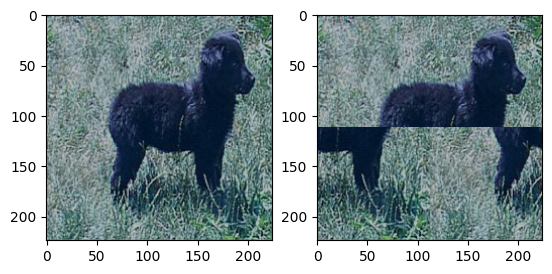

In [18]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(torch.permute(denormalize(img,mean, std),(1,2,0)));
axes[1].imshow(torch.permute(denormalize(premuted_img,mean, std),(1,2,0)));

In [42]:
def calculate_gradient(img, tiles_num=9):
    tiles_per_row = int(np.sqrt(tiles_num))
    x = int(img.shape[1] // tiles_per_row * tiles_per_row)
    y = int(img.shape[2] // tiles_per_row * tiles_per_row)
    img = img[:,:x, :y,]
    # pixel_size = int(img.shape[1] / tiles_per_row)
    tiles_edges_idx = np.linspace(0,img.shape[1], tiles_per_row + 1, dtype=int)[1:-1]
    gradient = torch.abs((img[:,:,tiles_edges_idx] - img[:,:,tiles_edges_idx-1])).sum().item()
    gradient += torch.abs((img[:,tiles_edges_idx,:] - img[:,tiles_edges_idx-1,:])).sum().item()
    return gradient


In [120]:
def calculate_gradient1(img, tiles_num=9):
    tiles_per_row = int(np.sqrt(tiles_num))
    x = int(img.shape[-2] // tiles_per_row * tiles_per_row)
    y = int(img.shape[-1] // tiles_per_row * tiles_per_row)
    img = img[...,:x, :y]
    # pixel_size = int(img.shape[1] / tiles_per_row)
    tiles_edges_idx = np.linspace(0,img.shape[-2], tiles_per_row + 1, dtype=int)[1:-1]
    gradient = torch.abs((img[...,tiles_edges_idx] - img[...,tiles_edges_idx-1])).sum().item()
    gradient += torch.abs((img[...,tiles_edges_idx,:] - img[...,tiles_edges_idx-1,:])).sum().item()
    return gradient

In [26]:
def permute_by_defined_premutations(img, permutations_set):
    permuted_imgs = []
    num_tiles = len(permutations_set[0])
    tiles_per_row = int(np.sqrt(num_tiles))
    x = int(img.shape[1] // tiles_per_row * tiles_per_row)
    y = int(img.shape[2] // tiles_per_row * tiles_per_row)
    img = img[:, :x, :y]
    channels, height, width = img.shape
    tile_width = int(width // tiles_per_row)
    tile_height = int(height // tiles_per_row)
    tiled_array = img.reshape(channels, tiles_per_row, tile_height, tiles_per_row, tile_width)
    tiled_array = tiled_array.swapaxes(2, 3)
    tiles = tiled_array.reshape(channels, num_tiles, tile_height, tile_width)
    for permutation in permutations_set:
        premuted_tiles= tiles[:, permutation]
        tiled_array = premuted_tiles.reshape(channels, tiles_per_row, tiles_per_row, tile_height, tile_width)
        tiled_array = tiled_array.swapaxes(2, 3)
        permuted_img = tiled_array.reshape(channels, height, width)
        permuted_imgs.append(permuted_img)
    return torch.stack(permuted_imgs)


In [27]:
images = permute_by_defined_premutations(img, list(premutation_dict.values()))

In [135]:
from numpy.linalg import norm

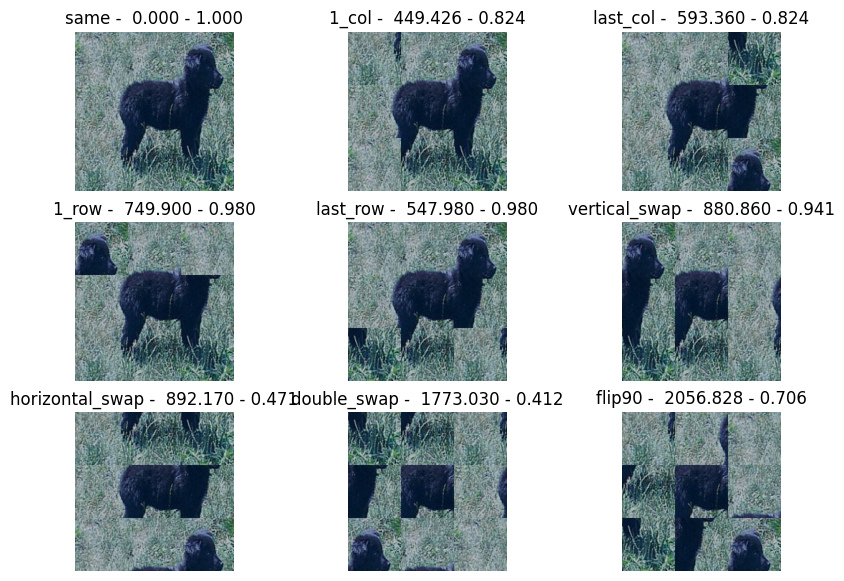

In [62]:
fig, axes = plt.subplots(3, 3, figsize=(10, 7))
axes = axes.flatten()
A= np.arange(tiles_num)
for i, key in enumerate(premutation_dict.keys()):
    # img = np.transpose(img, (1, 2, 0))  # Transpose to (H, W, C)
    axes[i].imshow(torch.permute(denormalize(images[i,:],mean,std),(1,2,0)))
    score = np.abs(base - calculate_gradient(images[i,:]))
    B = premutation_dict[key]
    cosine = np.dot(A,B)/(norm(A)*norm(B))
    axes[i].set_title(f'{key} - {score: 0.3f} - {cosine:0.3f}')
    axes[i].axis('off')
plt.show();

In [8]:
permuted_test_set = test.with_transform(Transform_Builder.build(224,with_premute=True, num_tiles=9, permutations_set= [premutation_dict['1_col']]))

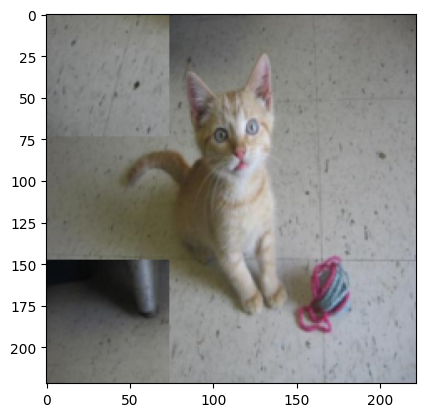

In [17]:

plt.imshow(torch.permute(denormalize(permuted_test_set[10]["image"],mean,std),(1,2,0)))

In [126]:
test_set = test.with_transform(Transform_Builder.build(224))
base_score = calculate_gradient1(torch.stack(test_set[:]['image']))

In [127]:
results = {'score': [], 'accuracy': []}
for premutation in premutation_dict.values():
        permuted_test_set = test.with_transform(Transform_Builder.build(224,with_premute=True, num_tiles=9, permutations_set= [premutation]))
        dataloader = DataLoader(permuted_test_set, batch_size=32, drop_last=True, num_workers=0)
        results['score'].append(np.abs(calculate_gradient1(torch.stack(permuted_test_set[:]['image']))-base_score))
        pretrained_model.predict_data(dataloader)
        results['accuracy'].append(pretrained_model.test_acc)

Test Acc: 0.987800
Test Acc: 0.981800
Test Acc: 0.980900
Test Acc: 0.954000
Test Acc: 0.980000
Test Acc: 0.987800
Test Acc: 0.969600
Test Acc: 0.954900
Test Acc: 0.932300
Test Acc: 0.906200


<Axes: xlabel='score', ylabel='accuracy'>

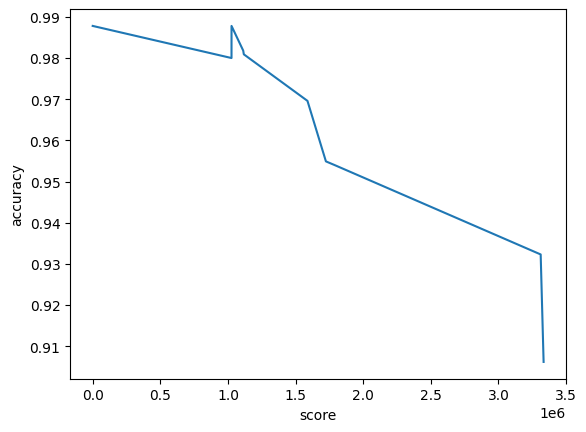

In [129]:
sns.lineplot(data= pd.DataFrame(results), y='accuracy', x='score')

In [ ]:
A = np.arange(tiles_num)
x = np.array(list(premutation_dict.values()))
cosine = np.dot(x,A)/(norm(A)**2)

In [151]:
results1 = {}
results1['score']  = (results['score'] / cosine) / len(test)
results1['accuracy'] = results['accuracy']
results1['cosine'] = cosine


<Axes: xlabel='score', ylabel='accuracy'>

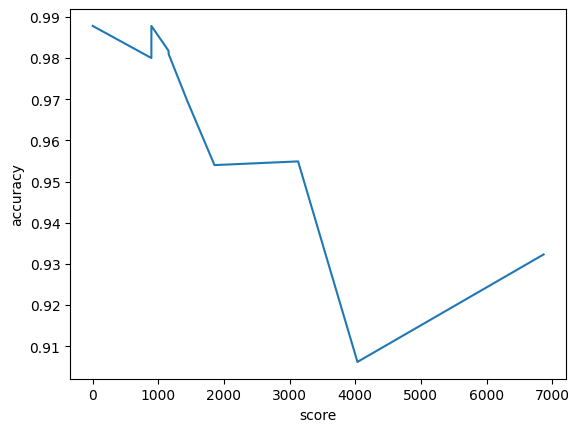

In [153]:
sns.lineplot(data= pd.DataFrame(results1), y='accuracy', x='score')

In [125]:
calculate_gradient1(torch.stack(permuted_test_set[:]['image']))

1474080.3125

In [124]:
score =  0
for img in torch.stack(permuted_test_set[:4]['image']):
    score += calculate_gradient(img)
print(score)

3938.0774993896484


In [14]:
pretrained_model.predict_data(dataloader)

Test Acc: 0.981800


### other stuff

In [182]:
num_permutations = 9

In [ ]:
def create_n_premutations(arr: np.array, n:int ,seed):
    np.random.seed(seed)
    permutations_set = set()
    while len(permutations_set) < n:
        perm = tuple(np.random.permutation(arr))
        permutations_set.add(perm)
    return list(permutations_set)

x = np.arange(9)
permutations_set = create_n_premutations(x, 9, SEED)

In [ ]:
permuted_images = [PermuteImage.permute_all(img.permute(1,2,0), permutations_set, num_tiles=9) for img in test_set[:]["image"]]
g = torch.stack(permuted_images)
g  = torch.permute(g,(0,1,4,2,3))

In [227]:
g[0,i,:]

torch.Size([1172, 3, 99, 99])

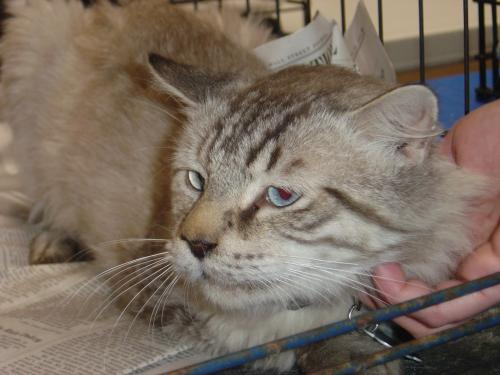

In [244]:
test[1]["image"]

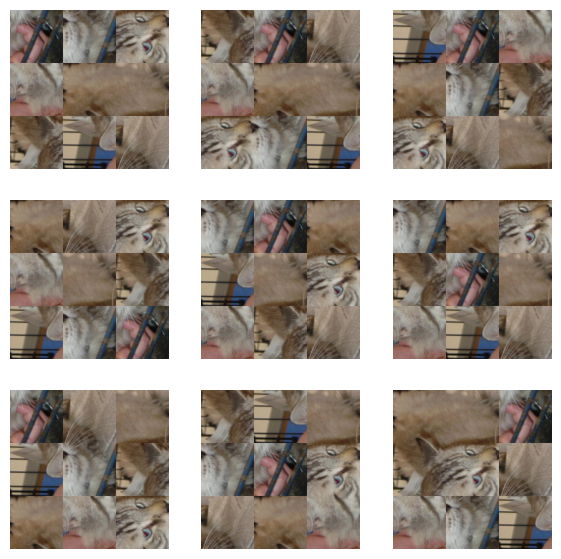

In [260]:
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.flatten()
for i in range(9):
    # img = np.transpose(img, (1, 2, 0))  # Transpose to (H, W, C)
    axes[i].imshow(torch.permute(denormalize(g[1,i,:],mean, std),(2,1,0)))
    axes[i].axis('off')
plt.show();

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {'image': self.images[idx], 'labels': self.labels[idx]}

In [261]:
results = {"Permutation_Type": [], "Accuracy": []}
for premutation in range(num_permutations):
    premuted_dataloader = DataLoader(CustomDataset(g[:,premutation,:],test_set["labels"]), batch_size=32, drop_last=True, num_workers=0)
    pretrained_model.predict_data(premuted_dataloader)
    results["Permutation_Type"].append(premutation)
    results["Accuracy"].append(pretrained_model.test_acc)

Test Acc: 0.906200
Test Acc: 0.922700
Test Acc: 0.926200
Test Acc: 0.914100
Test Acc: 0.912300
Test Acc: 0.916700
Test Acc: 0.922700
Test Acc: 0.930600
Test Acc: 0.959200
